## Gamma Ray Burst

Let's look at the latest database of Gamma Ray Bursts.

 - The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
 - You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html 


This edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research...). You have a cool dataset, explore it! Play with the data, apply some of the tecniques we have seen in classes so far, etc. **Be creative! You're discovering**


Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed? 



In [137]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from IPython.display import display, Math
import requests
import random
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth
import seaborn as sns 

plt.rc('text', usetex=True)  # Abilita l'uso di LaTeX in tutte le stringhe di testo
plt.rc('font', family='serif')

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [161]:
def kde_sklearn(data, bandwidth = 1.0, kernel="linear"):
    kde_skl = KernelDensity(bandwidth = bandwidth, 
                            kernel=kernel)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis]) # sklearn returns log(density)

    return np.exp(log_pdf)

In [138]:
# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])


In [139]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

## Histograms of some features

In [140]:
T90=np.array(data[6],dtype=float)
err_T90=np.array(data[7],dtype=float)
redshift=np.array(data[11],dtype=float)
T100=np.array(data[12],dtype=float)

mask = (T90 > 0) & (redshift > 0)


575 575


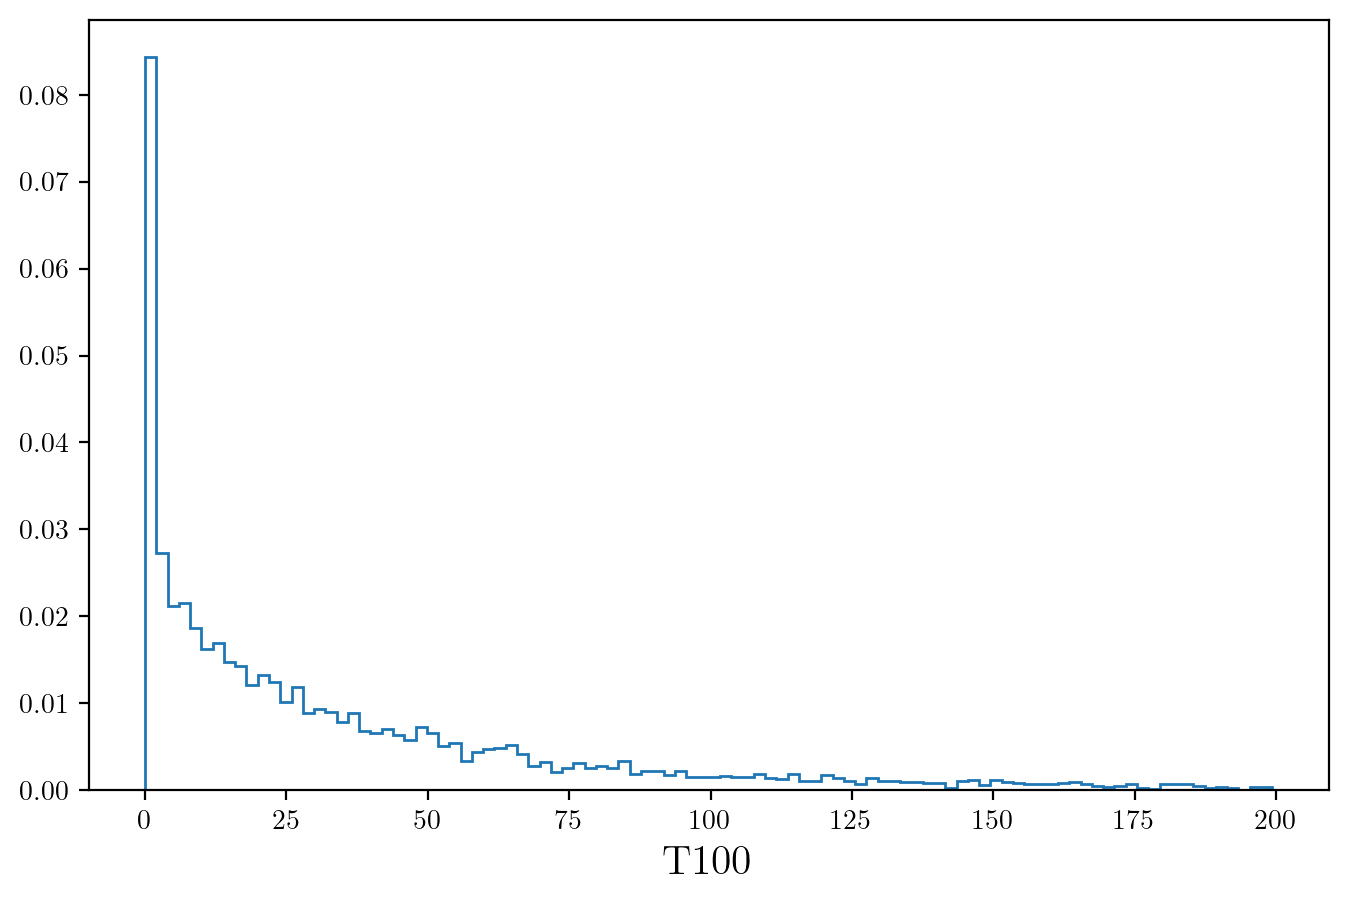

In [142]:
fig = plt.figure(figsize=(8, 5))
plt.hist(T100[(T100>0) & (T100<200)], bins=100, density=True, histtype='step')
#plt.hist(T90[T90>0], bins=100, density=True, histtype='step')
plt.xlabel('T100',fontsize=15)
plt.show()

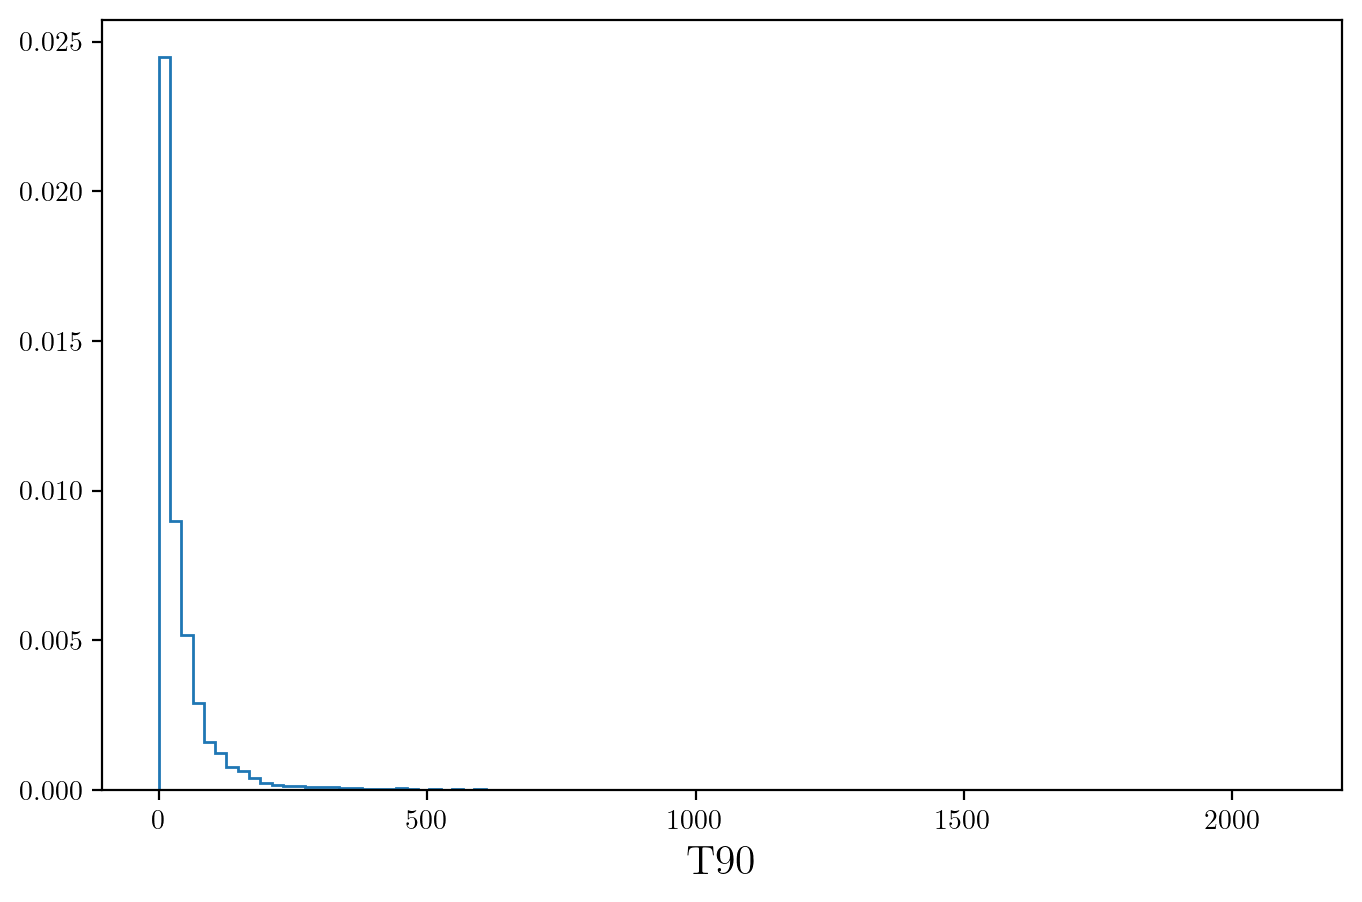

In [163]:
fig = plt.figure(figsize=(8, 5))
plt.hist(T90[T90>0], bins=100, density=True, histtype='step')
plt.xlabel('T90',fontsize=15)
plt.show()

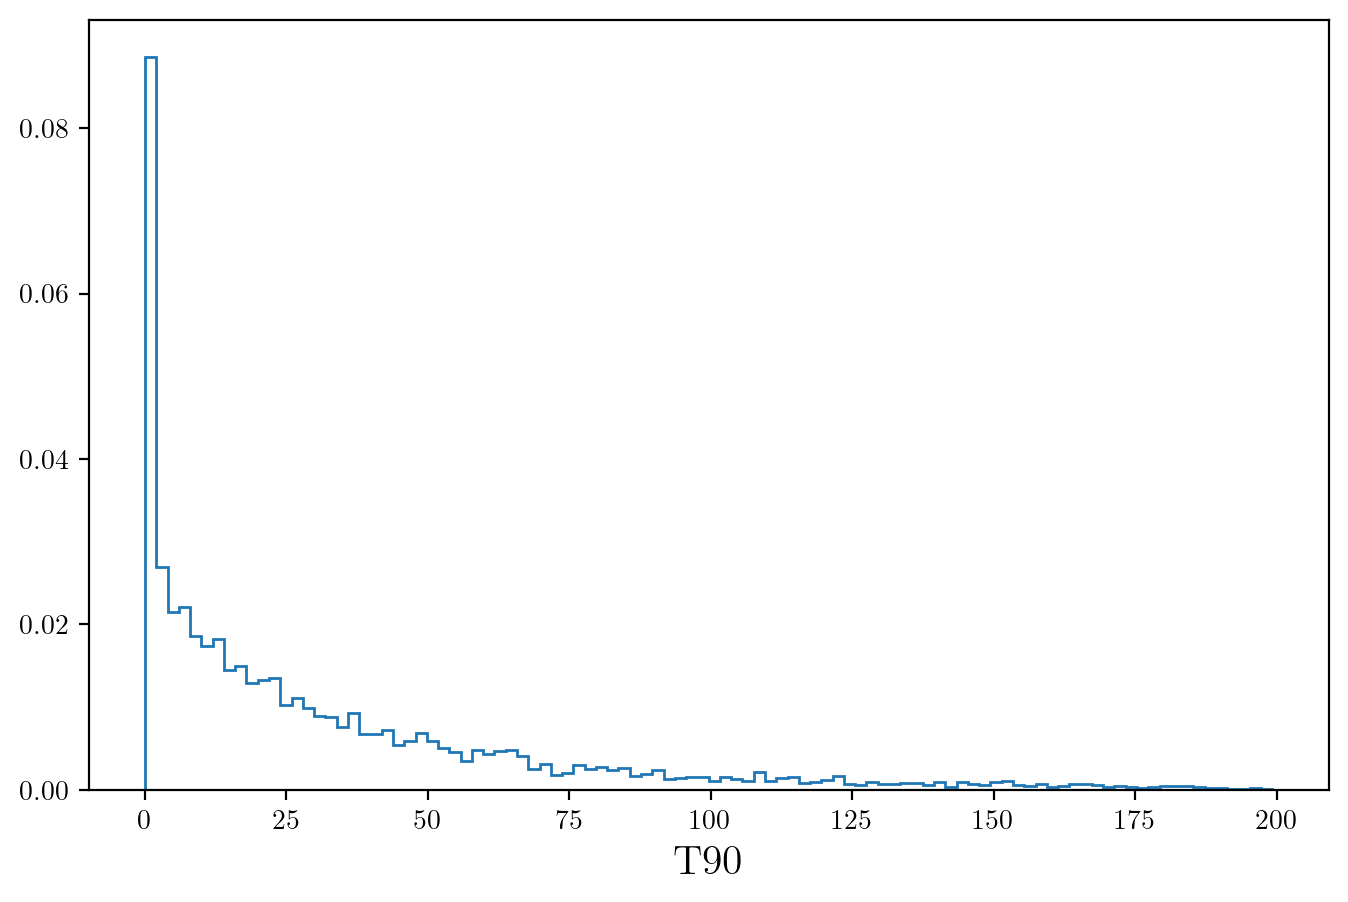

In [143]:
fig = plt.figure(figsize=(8, 5))
plt.hist(T90[(T90>0) & (T90<200)], bins=100, density=True, histtype='step')
plt.xlabel('T90',fontsize=15)
plt.show()

I have the feeling that T90 and T100 gives me the same info abut data

8539


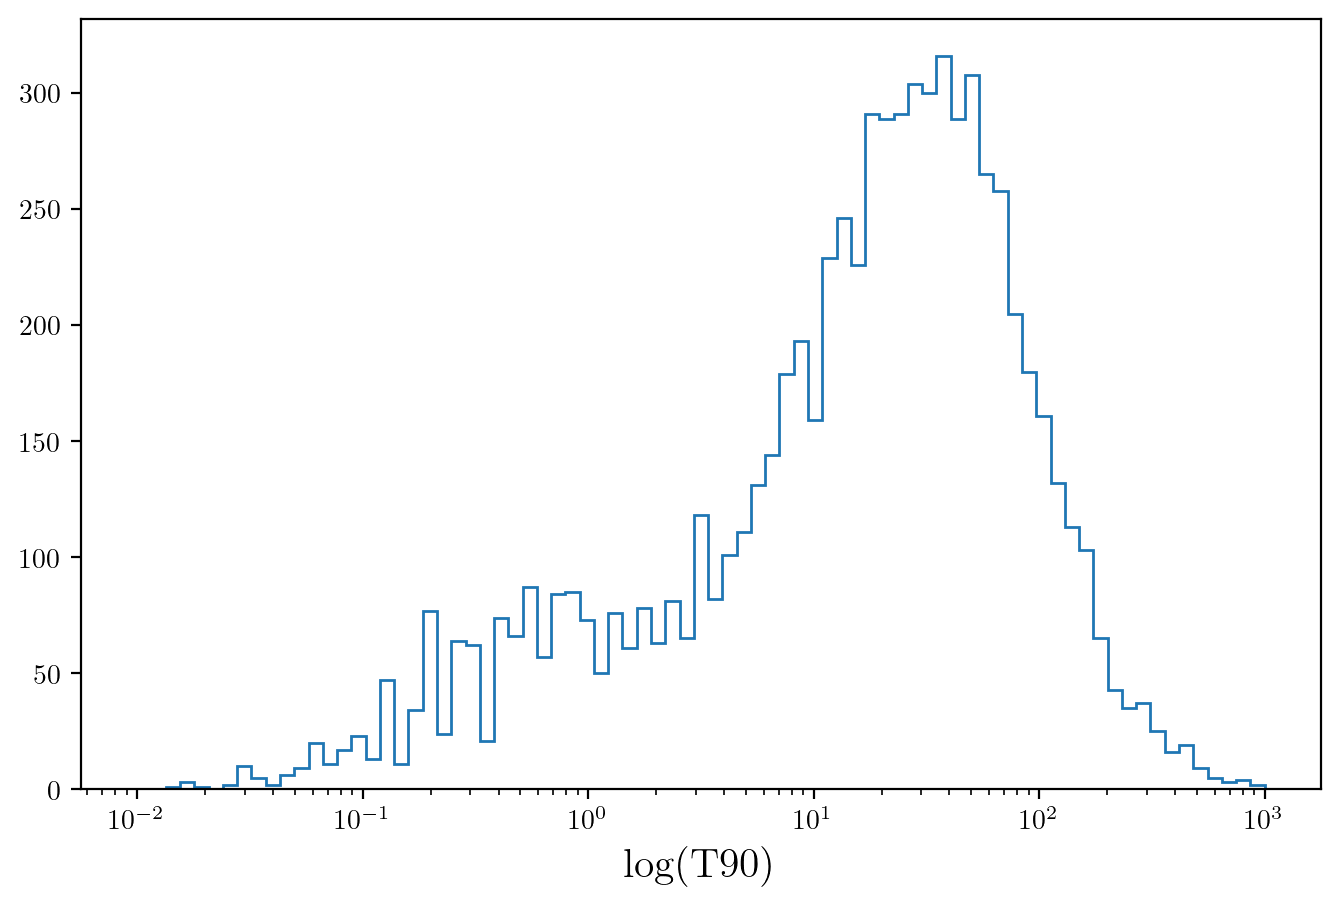

In [213]:

print(len(T90))
fig = plt.figure(figsize=(8, 5))
plt.hist(T90[T90>0], bins=np.logspace(-2,3,80), histtype='step')
plt.xlabel('log(T90)',fontsize=15)
plt.xscale('log')
plt.show()

### KDE with cross validation for choosing bandwidth

0.07847599703514611


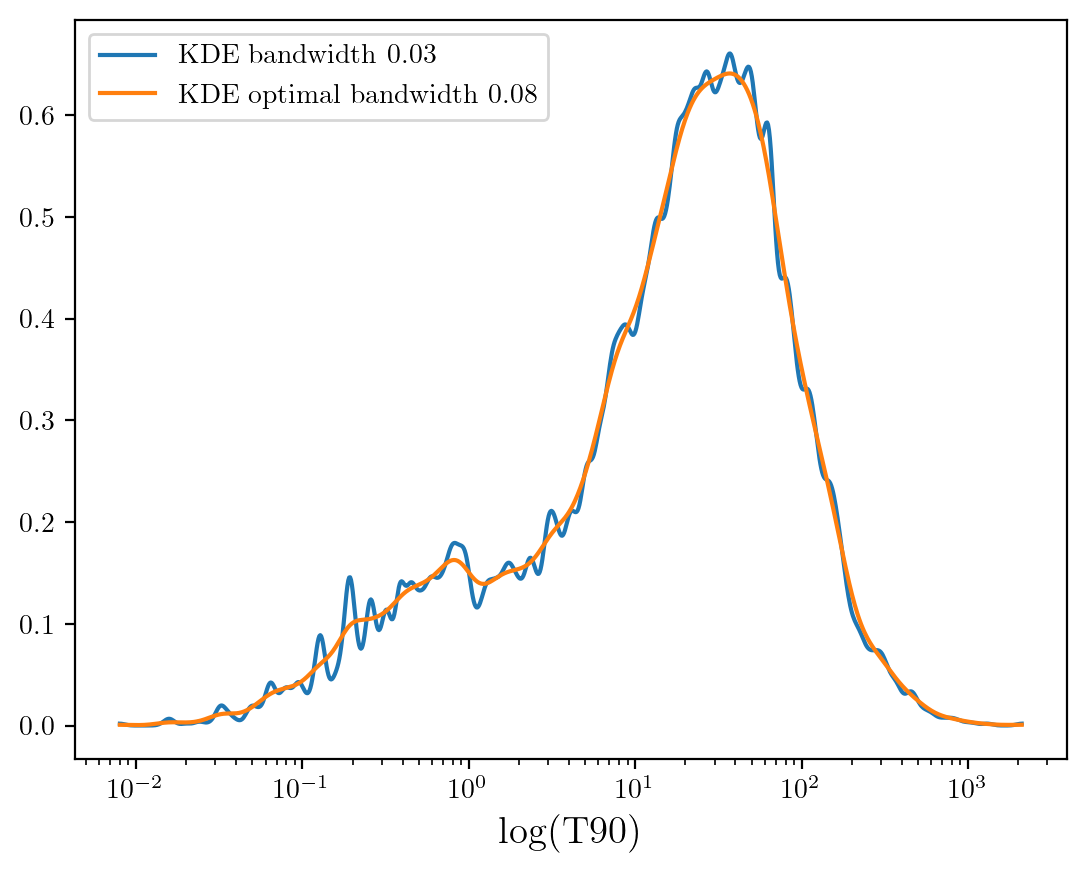

In [214]:
T90_log=np.log10(T90[T90>0])
bwrange = np.logspace(-3, 3, 20)
K = 5
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv=K)
grid.fit(T90_log[:, np.newaxis])
w_opt = grid.best_params_['bandwidth']
print(w_opt)

# grid for KDE in log space
xgrid = np.linspace(T90_log.min(), T90_log.max(), 1000)
w = 0.03

# KDE with manually selected bandwidth
PDF_manual = kde_sklearn(T90_log, bandwidth=w, kernel='gaussian')
plt.plot(10**xgrid, PDF_manual, label=f'KDE bandwidth {w}')

# KDE with optimized bandwidth
PDF_opt = kde_sklearn(T90_log, bandwidth=w_opt, kernel='gaussian')
plt.plot(10**xgrid, PDF_opt, label=f'KDE optimal bandwidth {w_opt:.2f}')

plt.xscale('log')
plt.xlabel('log(T90)', fontsize=14)

plt.legend()
plt.show()

## K means with 2 clusters for log(T90) histogram

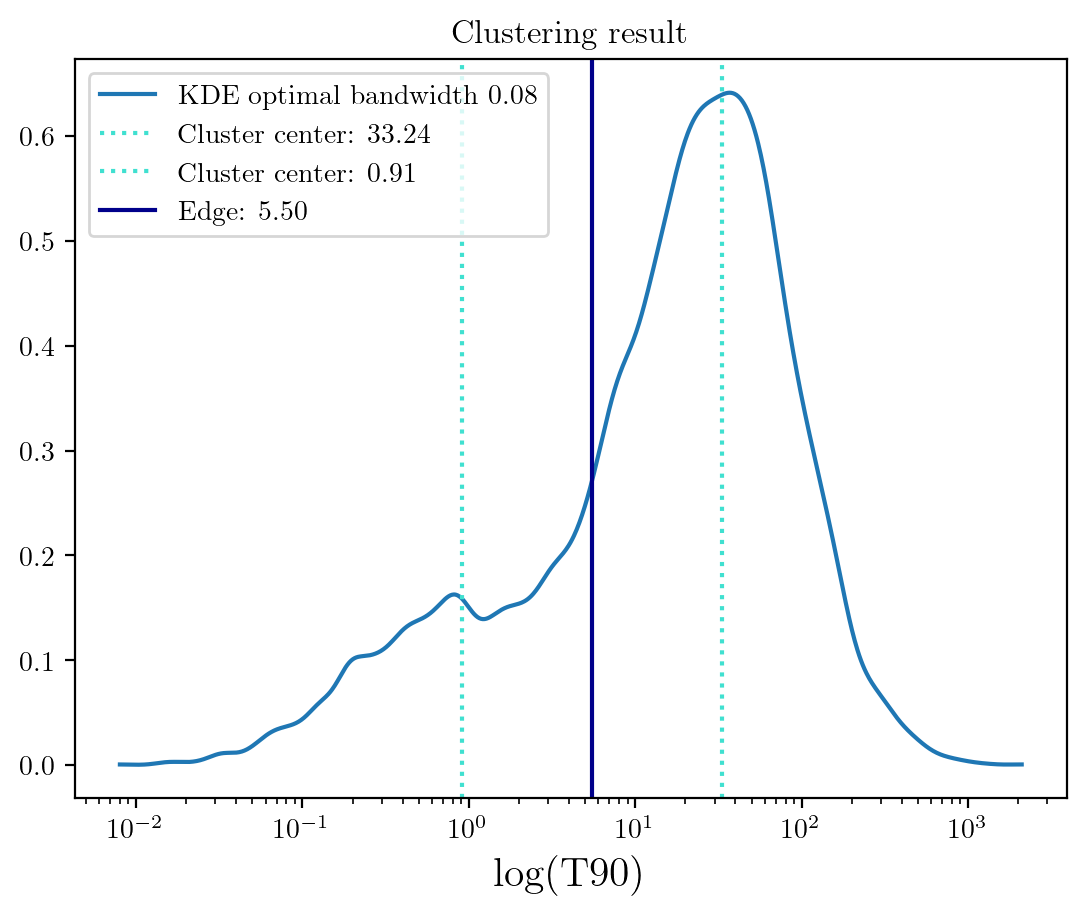

In [209]:
clf = KMeans(n_clusters=2,n_init='auto') #Try 2 clusters to start with
clf.fit(T90_log[:, np.newaxis])
centers = clf.cluster_centers_ #location of the clusters
labels = clf.predict(T90_log[:, np.newaxis])
edge = np.mean(centers)

colors = ['darkblue', 'turquoise']
plt.plot(10**xgrid, PDF_opt, label=f'KDE optimal bandwidth {w_opt:.2f}')
for c in centers:
    cen = 10**c
    plt.axvline(cen, color=colors[1], ls='dotted', label=f'Cluster center: {cen[0]:.2f}')
plt.axvline(10**edge, color=colors[0], label=f'Edge: {10**edge:.2f}')


plt.xscale('log')
plt.xlabel('log(T90)',fontsize=15)
plt.title('Clustering result')
plt.legend()
plt.show()

## MeanShift

In [210]:
b = estimate_bandwidth(T90_log[:, np.newaxis]) 
print(b)

0.5187845762406179


In [227]:
scaler = preprocessing.StandardScaler()
ms = MeanShift(bandwidth=b, 
               bin_seeding=True, 
               cluster_all=False)
ms.fit(scaler.fit_transform(T90_log[:, np.newaxis]))

labels_unique = np.unique(ms.labels_)
n_clusters = len(labels_unique[labels_unique >= 0])

cluster_centers = ms.cluster_centers_
cluster_centers_original = scaler.inverse_transform(cluster_centers)

print(labels_unique)
print("number of estimated clusters :", n_clusters)

[-1  0  1]
number of estimated clusters : 2
edges between the clusters: <generator object <genexpr> at 0x7f8a3d2a11c0>


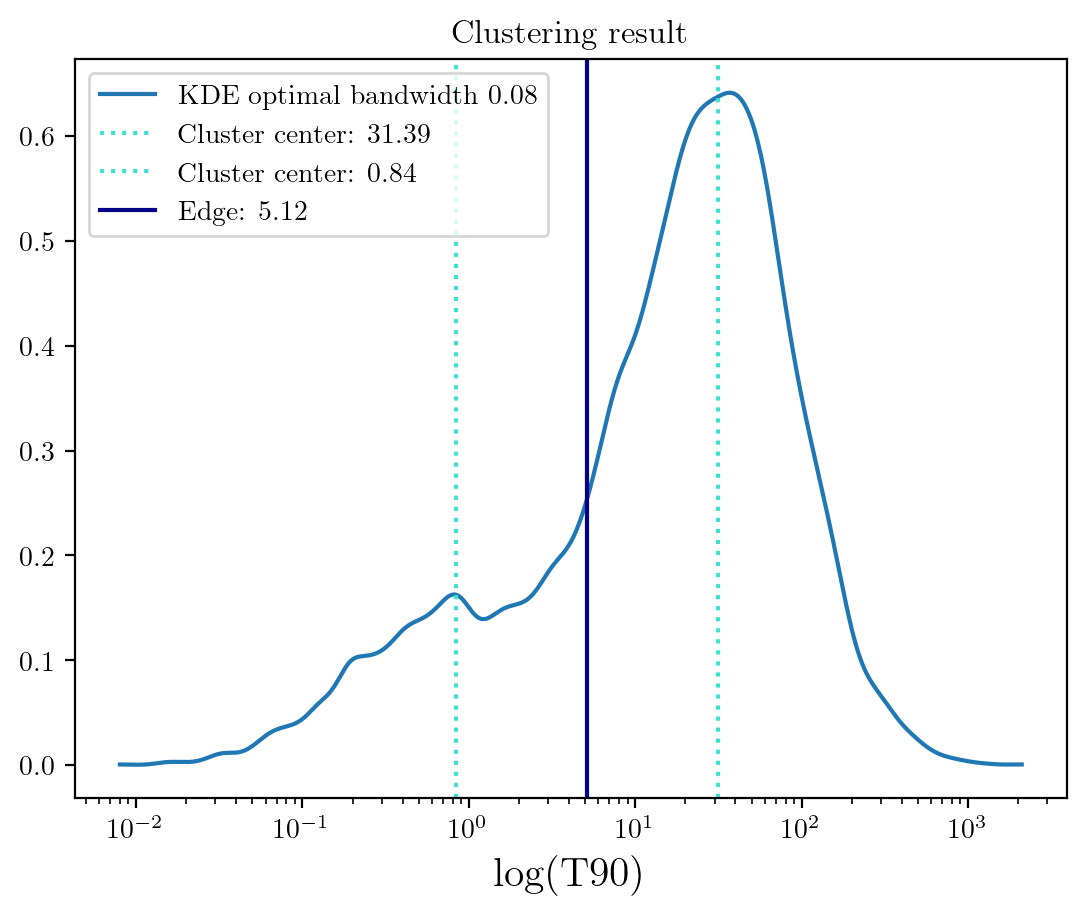

In [229]:
edge = np.mean(cluster_centers_original) #only bc I know that meanshift has estimated 2 clusters
plt.plot(10**xgrid, PDF_opt, label=f'KDE optimal bandwidth {w_opt:.2f}')
for c in cluster_centers_original:
    cen = 10**c
    plt.axvline(cen, color=colors[1], ls='dotted', label=f'Cluster center: {cen[0]:.2f}')
plt.axvline(10**edge, color=colors[0], label=f'Edge: {10**edge:.2f}')

plt.xscale('log')
plt.xlabel('log(T90)',fontsize=15)
plt.title('Clustering result')
plt.legend()
plt.show()

I had a result very close to before!

## RedShift

In [188]:
np.log(max(redshift))

2.3978952727983707

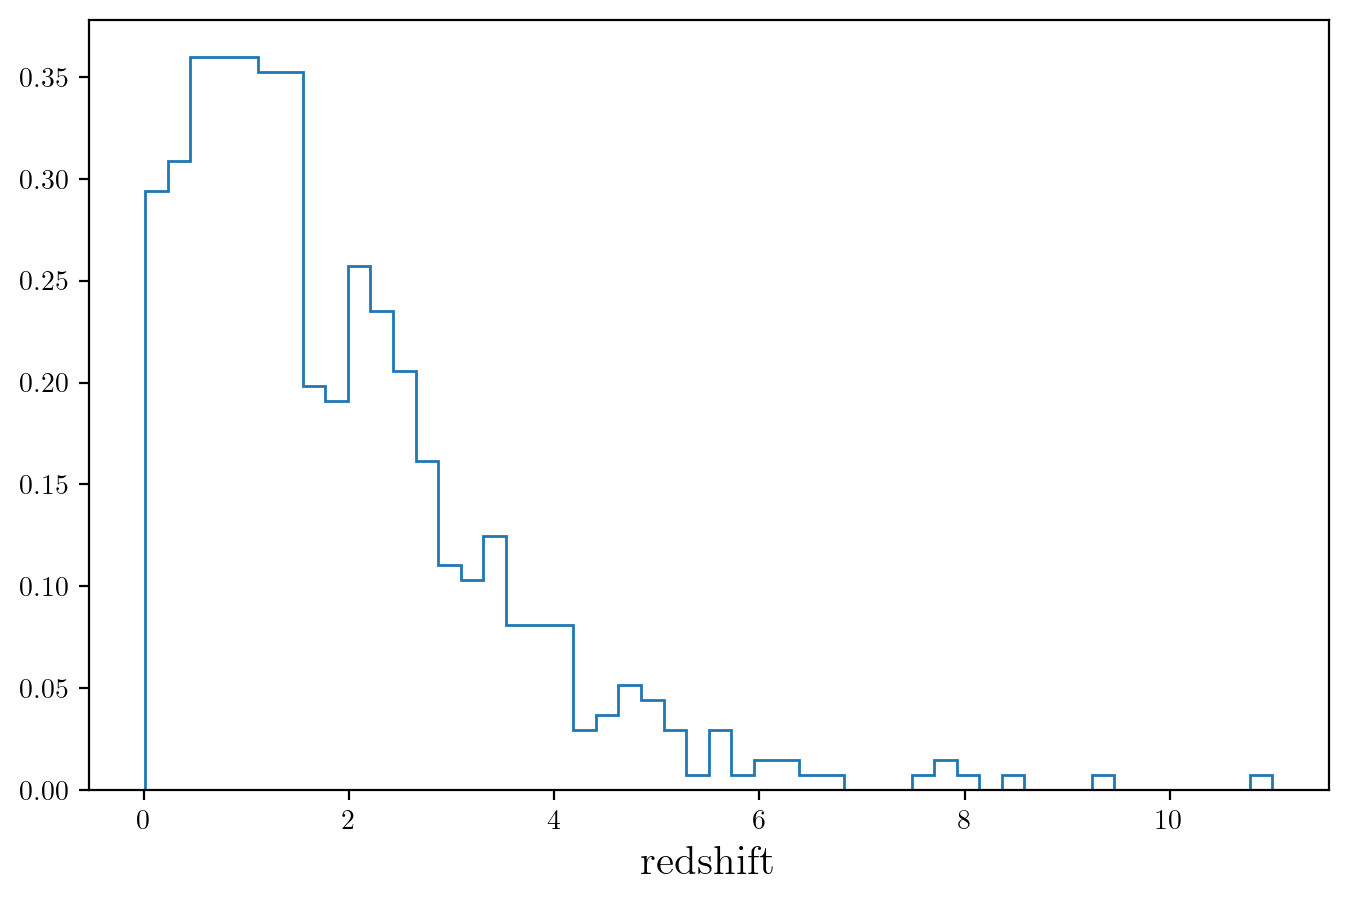

In [189]:
fig = plt.figure(figsize=(8, 5))
plt.hist(redshift[redshift>0], bins=50, density=True, histtype='step')
plt.xlabel('redshift',fontsize=15)
plt.show()

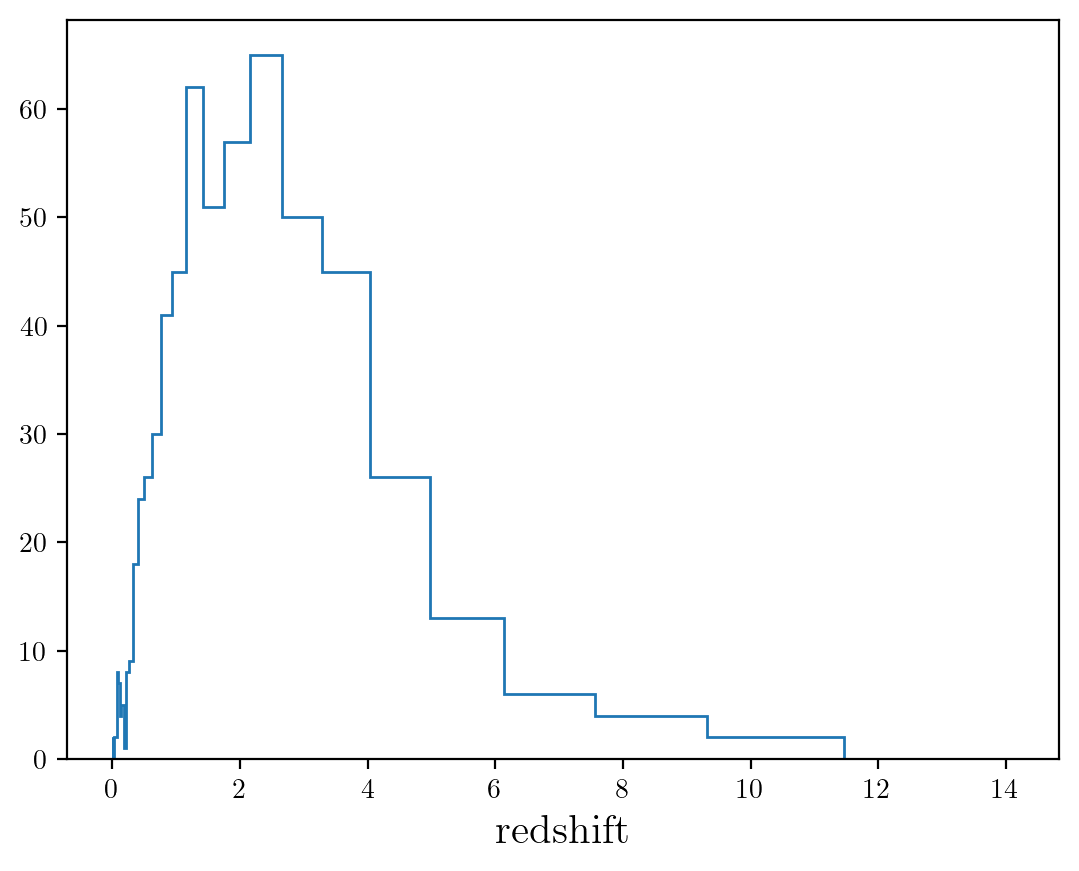

In [167]:
plt.hist(redshift[redshift>0], bins=np.logspace(-6,1.15,80), histtype='step')
plt.xlabel('redshift',fontsize=15)
plt.show()

In [ ]:
#try to searck for the optimal bandwidth kde

### KDE with cross validation for choosing bandwidth

0.495


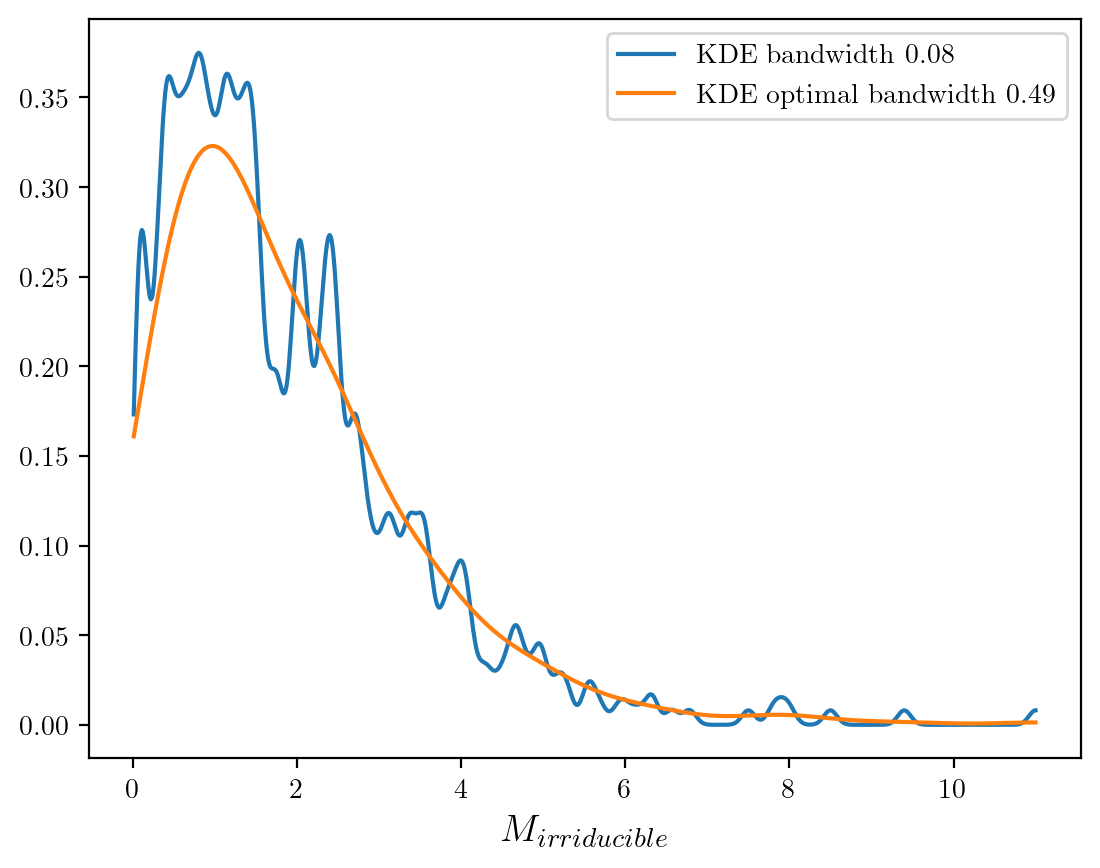

In [165]:
bwrange = np.linspace(0.0001,1.0, 100) 

K = 5 # Do 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= K) # Try each bandwidth with K-folds
grid.fit(redshift[redshift>0, np.newaxis]) #Fit the histogram data that we started the lecture with.
w_opt = grid.best_params_['bandwidth']
print(w_opt)

w=0.08
xgrid=np.linspace(redshift[redshift>0].min(), redshift[redshift>0].max(), 1000)

PDFtophat = kde_sklearn(redshift[redshift>0],bandwidth=w,kernel="gaussian")
plt.plot(xgrid,PDFtophat, label=f'KDE bandwidth {w}')

PDFtophat = kde_sklearn(redshift[redshift>0],bandwidth=w_opt,kernel="gaussian")
plt.plot(xgrid,PDFtophat, label=f'KDE optimal bandwidth {w_opt:.2f}')

plt.xlabel('redshift', fontsize=14)

plt.legend()
plt.show()

# VALUTA SE TENERE DA QUA IN POI

## T90 vs Redshift

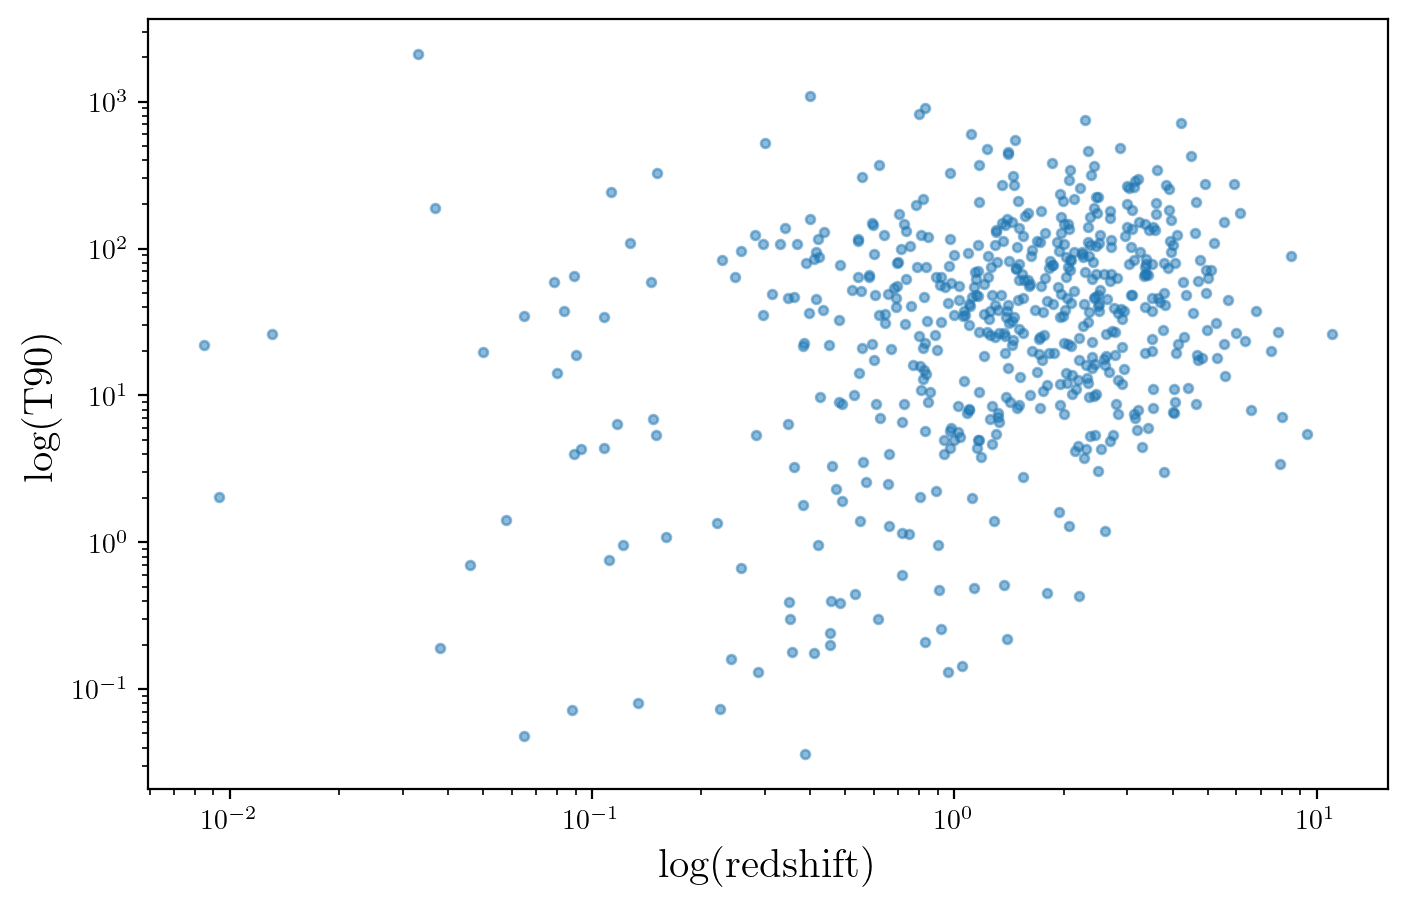

In [230]:
err_T90[err_T90<0] = 0

fig = plt.figure(figsize=(8, 5))
plt.scatter(redshift[mask], T90[mask], alpha=0.5, s=10)

plt.xlabel('log(redshift)',fontsize=15)
plt.ylabel('log(T90)',fontsize=15)
plt.yscale('log')
plt.xscale('log')
plt.show()

In [231]:
#try clustering on this last plot

## K means with 2 clusters

In [232]:
rt=np.column_stack((np.log(redshift[mask]), np.log(T90[mask])))
print(rt.shape)

(575, 2)


[[-0.25119085  1.0325687 ]
 [ 0.44220658  4.18138231]]


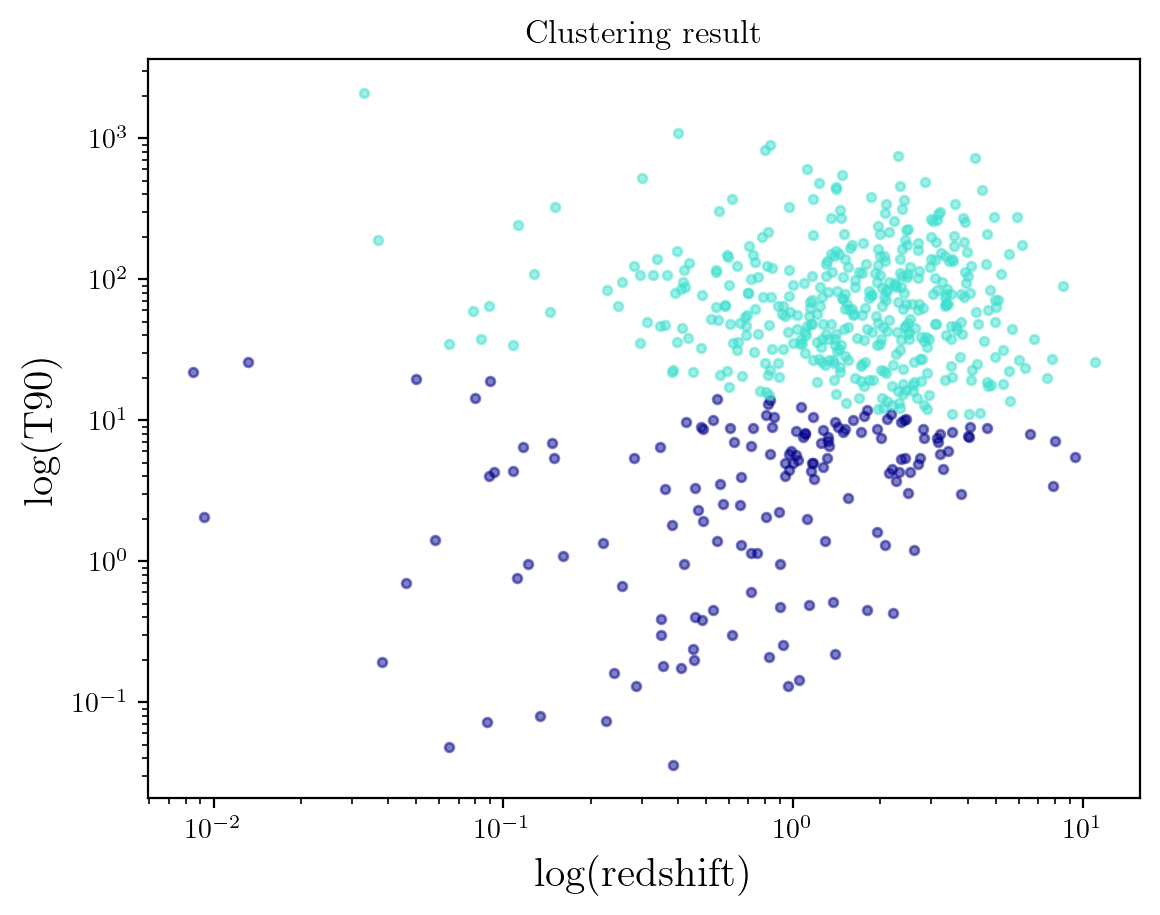

In [239]:
clf = KMeans(n_clusters=2,n_init='auto') #Try 2 clusters to start with
clf.fit(rt)
centers = clf.cluster_centers_ #location of the clusters
labels = clf.predict(rt)
print(centers)
colors = ['darkblue', 'turquoise']
for ii in range(2):
    plt.scatter(redshift[mask][labels==ii], T90[mask][labels==ii], 
                color=colors[ii],alpha=0.5, s=10, label=f'cluster {ii+1}, center:{centers[ii][1]:.2f}')

plt.xlabel('log(redshift)',fontsize=15)
plt.ylabel('log(T90)',fontsize=15)
plt.yscale('log')
plt.xscale('log')
plt.title('Clustering result')
plt.show()

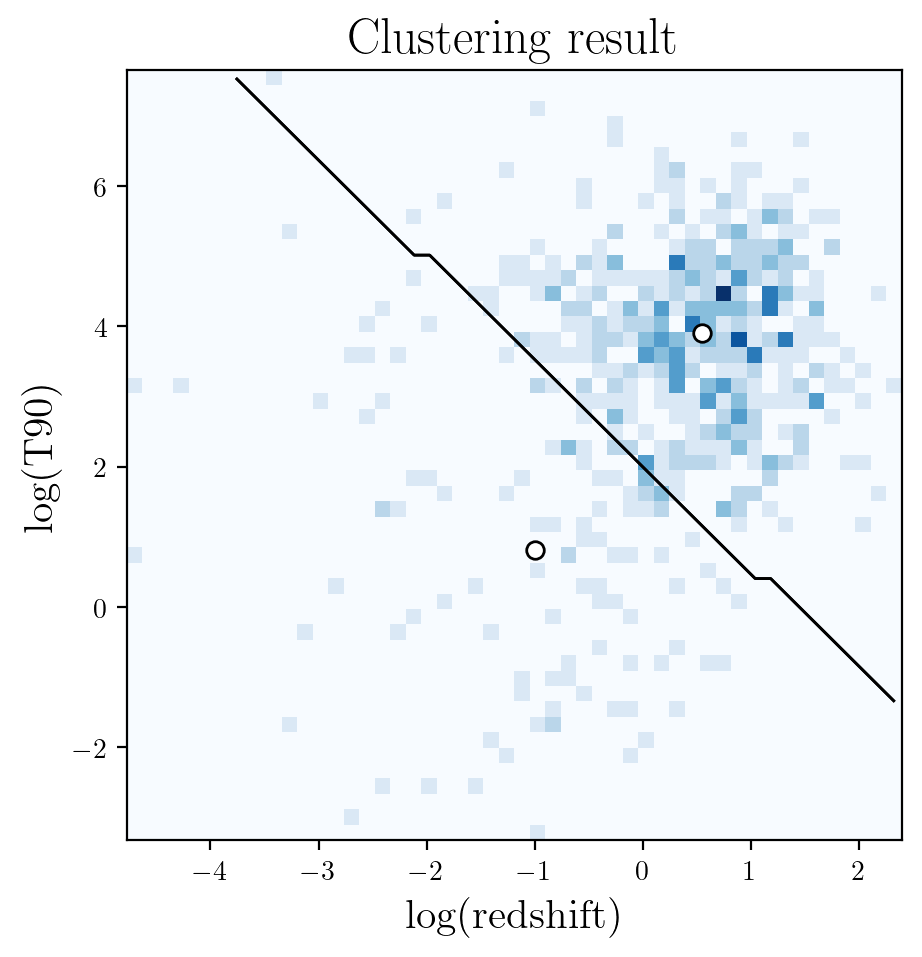

In [79]:
scaler = preprocessing.StandardScaler()
clf.fit(scaler.fit_transform(rt))
# Make some plots
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(data[:,0], data[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Blues')

# plot cluster centers
cluster_centers = scaler.inverse_transform(clf.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = clf.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(2):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')

    H = clf.predict(scaler.transform(Xgrid)).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel('log(redshift)',fontsize=15)
ax.set_ylabel('log(T90)',fontsize=15)
plt.title('Clustering result', fontsize=18)

plt.show()

## MeanShift 

In [119]:
b = estimate_bandwidth(rt) 
print(b)

1.6543822036631592


[-1  0  1  2]
Number of estimated clusters: 4


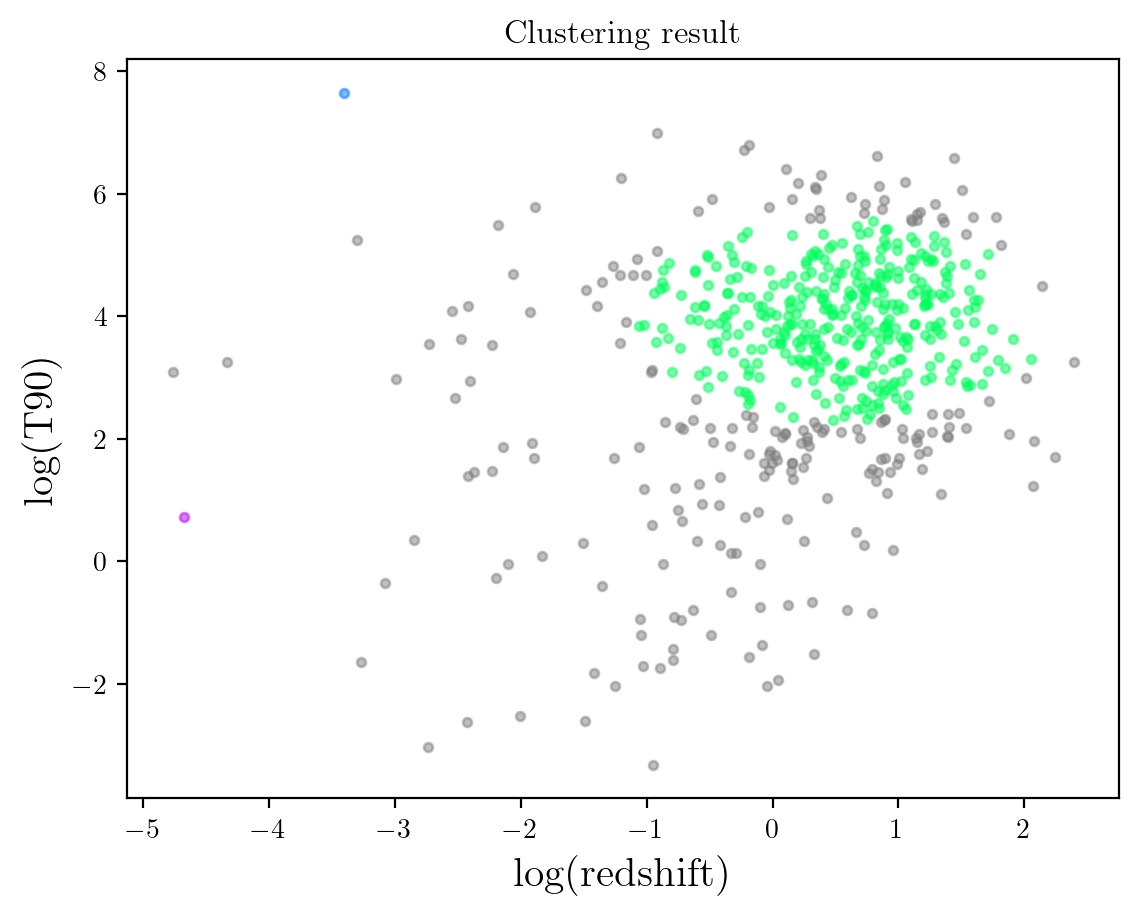

In [124]:
ms = MeanShift(bandwidth=bandwidth, 
               bin_seeding=True, 
               cluster_all=False)

ms.fit(rt)
labels_unique = np.unique(labels)
n_clusters = len(labels_unique)
print(labels_unique)
print(f"Number of estimated clusters: {n_clusters}")

colors = sns.color_palette("hsv", n_clusters)

# Visualizza i cluster
for ii, label in enumerate(labels_unique):
    if label == -1:
        # Colore speciale per i punti di rumore
        plt.scatter(rt[labels == -1, 0], rt[labels == -1, 1], 
                    color='gray', alpha=0.5, s=10, label='Noise')
    else:
        plt.scatter(rt[labels == label, 0], rt[labels == label, 1], 
                    color=colors[ii], alpha=0.5, s=10, label=f'Cluster {label}')
        
plt.xlabel('log(redshift)', fontsize=15)
plt.ylabel('log(T90)', fontsize=15)
plt.title('Clustering result')
plt.show()

In [125]:
#risultato assai strano(?)

In [126]:
scaler = preprocessing.StandardScaler()
ms = MeanShift(bandwidth=b, 
               bin_seeding=True, 
               cluster_all=False)
ms.fit(scaler.fit_transform(rt))

labels_unique = np.unique(ms.labels_)
n_clusters = len(labels_unique[labels_unique >= 0])
print(labels_unique)
print(bandwidth)
print("number of estimated clusters :", n_clusters)

[-1  0]
1.6543822036631592
number of estimated clusters : 1


#### so with the estimated bandwith it doesn't find more than one cluster, I'll try to decrease it

In [127]:
ms = MeanShift(bandwidth=b-0.3, 
               bin_seeding=True, 
               cluster_all=False)
ms.fit(scaler.fit_transform(rt))

labels_unique = np.unique(ms.labels_)
n_clusters = len(labels_unique[labels_unique >= 0])
print(labels_unique)
print(bandwidth)
print("number of estimated clusters :", n_clusters)

[-1  0  1]
1.6543822036631592
number of estimated clusters : 2


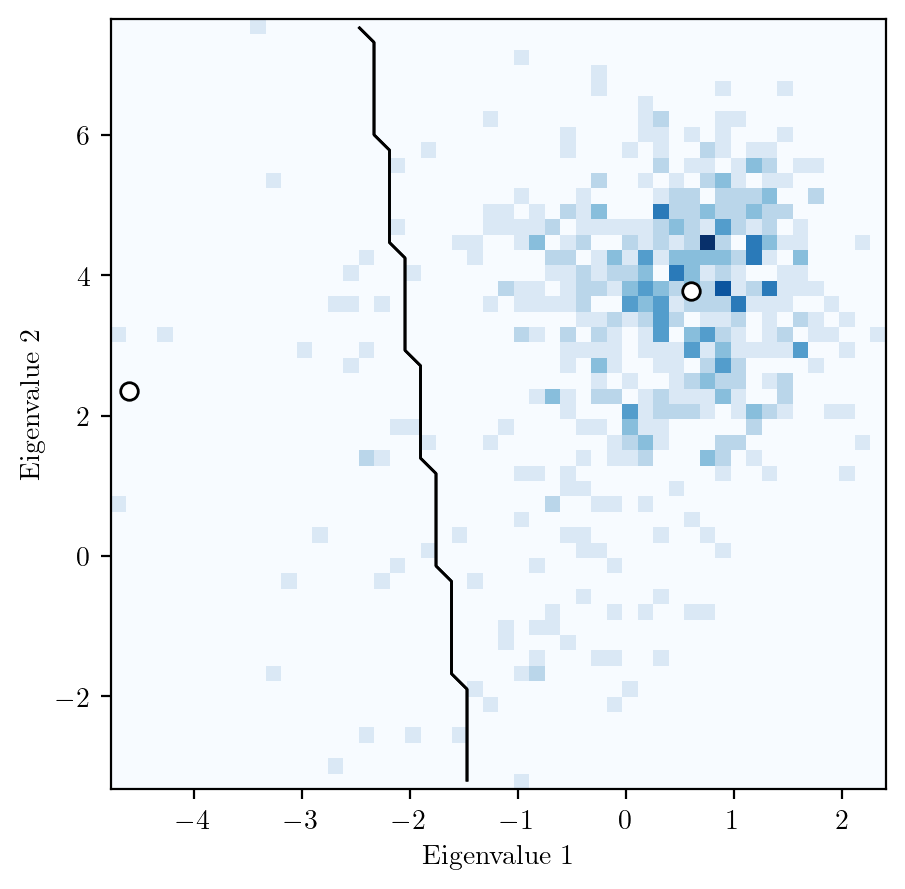

In [128]:
# Make some plots
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(rt[:,0], rt[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Blues')

# plot cluster centers
cluster_centers = scaler.inverse_transform(ms.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')
 
    H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel('Eigenvalue 1')
ax.set_ylabel('Eigenvalue 2')

plt.show()

#### Decreasing even more

In [129]:
ms = MeanShift(bandwidth=b-0.5, 
               bin_seeding=True, 
               cluster_all=False)
ms.fit(scaler.fit_transform(rt))

labels_unique = np.unique(ms.labels_)
n_clusters = len(labels_unique[labels_unique >= 0])
print(labels_unique)
print(bandwidth)
print("number of estimated clusters :", n_clusters)

[-1  0  1  2]
1.6543822036631592
number of estimated clusters : 3


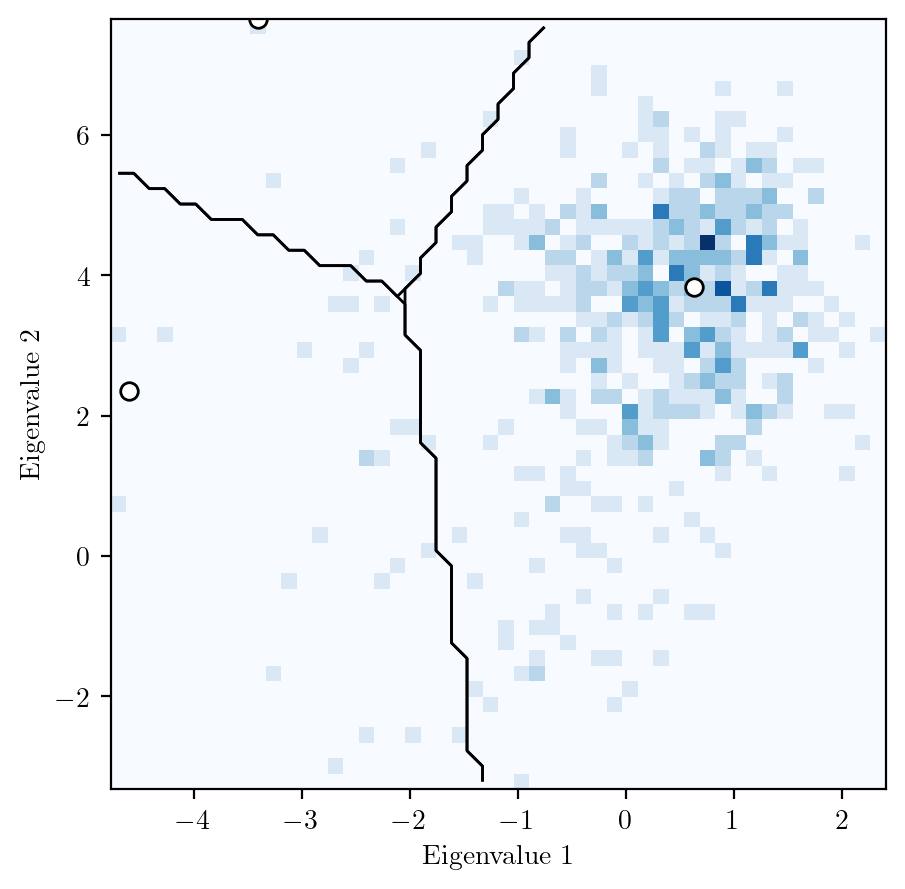

In [130]:
# Make some plots
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(rt[:,0], rt[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Blues')

# plot cluster centers
cluster_centers = scaler.inverse_transform(ms.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')
 
    H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

plt.show()